 # Export phase energies as a table

This snippet can be used to export the results of a calculation to a Pandas `DataFrame` object.

In [8]:
from pycalphad import Workspace, variables as v
from pycalphad.property_framework.metaproperties import IsolatedPhase
import pandas as pd

wks = Workspace('alzn_mey.tdb', ['AL', 'ZN'],
                ['FCC_A1', 'HCP_A3', 'LIQUID'],
                {v.X('ZN'):(0,1,0.02), v.T: (300, 1000, 10), v.P:101325, v.N: 1})

props = [v.T, v.X('AL'), v.X('ZN')]
for phase_name in wks.phases:
    prop = IsolatedPhase(phase_name, wks)(f'NP({phase_name})')
    prop.display_name = f'GM({phase_name})'
    props.append(prop)

data = {f'{key.display_name} [{key.display_units}]': value.reshape(-1)
        for key, value in wks.get_dict(*props).items()}

pd.DataFrame(data)

,Temperature [kelvin],X_AL [fraction],X_ZN [fraction],GM(FCC_A1) [fraction],GM(HCP_A3) [fraction],GM(LIQUID) [fraction]
0,300.0,1.00,1.000000e-10,1.0,1.0,1.0
1,300.0,0.98,2.000000e-02,1.0,1.0,1.0
2,300.0,0.96,4.000000e-02,1.0,1.0,1.0
3,300.0,0.94,6.000000e-02,1.0,1.0,1.0
4,300.0,0.92,8.000000e-02,1.0,1.0,1.0
...,...,...,...,...,...,...
3495,990.0,0.10,9.000000e-01,1.0,1.0,1.0
3496,990.0,0.08,9.200000e-01,1.0,1.0,1.0
3497,990.0,0.06,9.400000e-01,1.0,1.0,1.0
3498,990.0,0.04,9.600000e-01,1.0,1.0,1.0


# Plot energy curves for several phases

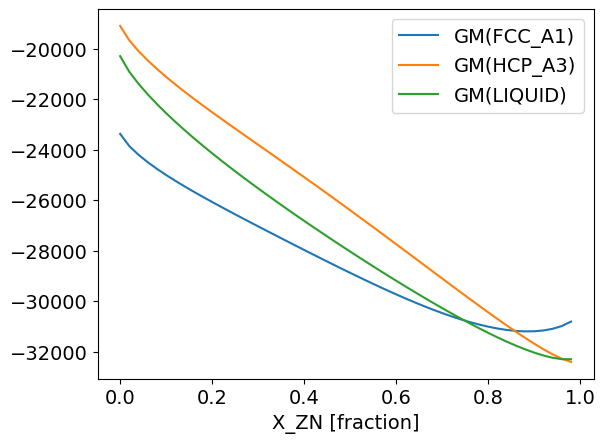

In [36]:
from pycalphad import Workspace, variables as v
from pycalphad.property_framework.metaproperties import IsolatedPhase
import matplotlib.pyplot as plt

wks2 = Workspace('alzn_mey.tdb', ['AL', 'ZN'],
                ['FCC_A1', 'HCP_A3', 'LIQUID'],
                {v.X('ZN'):(0,1,0.02), v.T: 670, v.P:101325, v.N: 1})

fig = plt.figure()
ax = fig.add_subplot()

x = wks2.get(v.X('ZN'))
ax.set_xlabel(f"{v.X('ZN').display_name} [{v.X('ZN').display_units}]")

for phase_name in wks2.phases:
    # Workaround for poor starting point selection in IsolatedPhase
    metastable_wks = wks2.copy()
    metastable_wks.phases = [phase_name]
    prop = IsolatedPhase(phase_name, metastable_wks)(f'GM({phase_name})')
    prop.display_name = f'GM({phase_name})'
    ax.plot(x, wks2.get(prop), label=prop.display_name)
ax.legend()

Text(0.5, 0, 'Mol Fraction Phase')

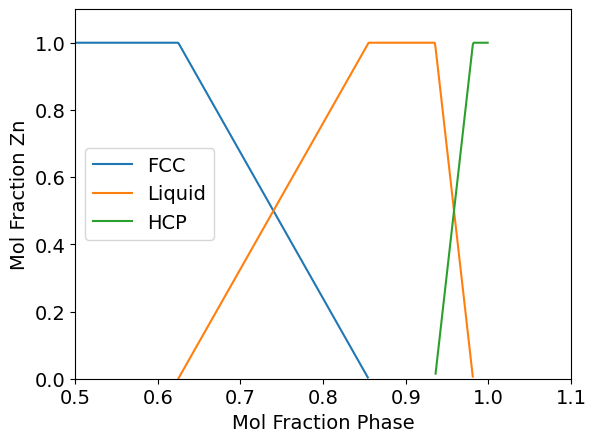

In [37]:
from pycalphad import Workspace, variables as v
from pycalphad.property_framework.metaproperties import IsolatedPhase
import matplotlib.pyplot as plt

wks2 = Workspace('alzn_mey.tdb', ['AL', 'ZN'],
                ['FCC_A1', 'HCP_A3', 'LIQUID'],
                {v.X('ZN'):(0,1,0.001), v.T: 670, v.P:101325, v.N: 1})

fig = plt.figure()

plt.rcParams.update({'font.size':14})
ax = fig.add_subplot()

ax.plot(wks2.get(v.X('ZN')), wks2.get('NP(FCC_A1)'), label='FCC')
ax.plot(wks2.get(v.X('ZN')), wks2.get('NP(LIQUID)'), label='Liquid')
ax.plot(wks2.get(v.X('ZN')), wks2.get('NP(HCP_A3)'), label='HCP')

ax.set_xlim(0.5,1.1)
ax.set_ylim(0,1.1)

ax.legend()

ax.set_ylabel('Mol Fraction Zn')
ax.set_xlabel('Mol Fraction Phase')

# Driving force calculation

Text(0, 0.5, 'Liquid Driving Force [J / mol]')

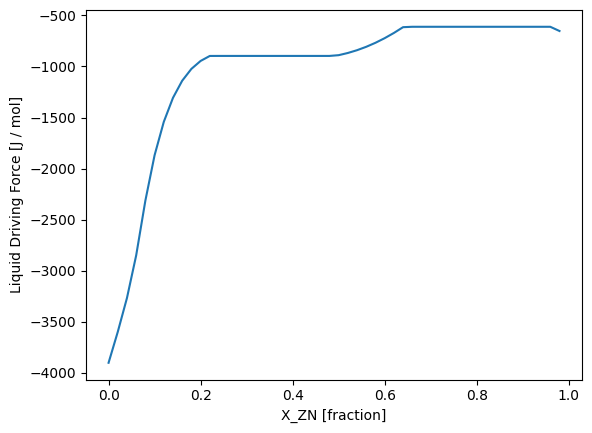

In [3]:
from pycalphad import Workspace, variables as v
from pycalphad.property_framework.metaproperties import DormantPhase

wks3 = Workspace('alzn_mey.tdb', ['AL', 'ZN'],
                ['FCC_A1', 'HCP_A3', 'LIQUID'],
                {v.X('ZN'):(0,1,0.02), v.T: 600, v.P:101325, v.N: 1})
metastable_liq_wks = wks3.copy()
metastable_liq_wks.phases = ['LIQUID']
liq_driving_force = DormantPhase('LIQUID', metastable_liq_wks).driving_force
liq_driving_force.display_name = 'Liquid Driving Force'

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(wks3.get(v.X('ZN')), wks3.get(liq_driving_force))
ax.set_xlabel(f"{v.X('ZN').display_name} [{v.X('ZN').display_units}]")
ax.set_ylabel(f"{liq_driving_force.display_name} [{liq_driving_force.display_units}]")

# Calculate T0 (t-zero) as a function of composition

The T0 (t-zero) temperature is a thermodynamic condition in which two specified phases have the same value of the Gibbs energy. Below T0, a so-called "massive" phase transition is thermodynamically favored to occur, without a barrier to diffusion.

Text(0, 0.5, 'T0(FCC_A1,HCP_A3) [kelvin]')

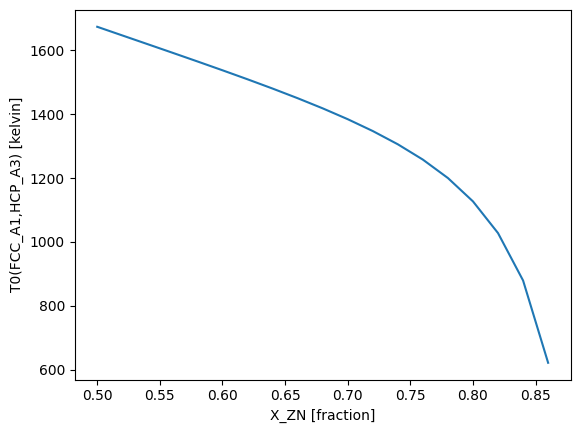

In [4]:
from pycalphad.property_framework.tzero import T0

# For T0, conditions must be one-dimensional (step calculation)
wks4 = Workspace('alzn_mey.tdb', ['AL', 'ZN'],
                ['FCC_A1', 'HCP_A3', 'LIQUID'],
                {v.X('ZN'): (0,1,0.02), v.T: 300, v.P:101325, v.N: 1})
tzero = T0('FCC_A1', 'HCP_A3', wks4)
tzero.maximum_value = 1700 # set temperature limit

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(wks4.get(v.X('ZN')), wks4.get(tzero))
ax.set_xlabel(f"{v.X('ZN').display_name} [{v.X('ZN').display_units}]")
ax.set_ylabel(f"{tzero} [{tzero.display_units}]")